# Continuous Control - 20 Agents

---

Project 2 - [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)

### 1. Start the Environment

Importing necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
import pandas as pd
from util import Agent_20, set_all_fontsizes

### 2. Set the correct path to Unity environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are running on Linux, then you downloaded `Reacher.x86` and `Reacher.x86_64`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = 'Reacher.x86_64'
```

In [2]:
env_path_n_file_name = 'Reacher_Linux_20/Reacher.x86_64'

### 3. Choose between TRAIN or ANALYSIS ONLY
If the `train` variable below is set to True, the training loop begins. If set to False the notebook only evaluates the cells related to analysis of results. With this way of hindering training, one can just restart and rerun entire notebook when in analysis mode if needed, instead of evaluating cell by cell.

train = False

In [3]:
train = False

### 4. Train

In [4]:
if train:
    agent = Agent_20(state_size=33, action_size=4, num_agents=20, random_seed=10)
    env = UnityEnvironment(file_name=env_path_n_file_name)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    def run_ddpg(n_episodes=2000, max_t=1000):
        scores_deque = deque(maxlen=100)
        scores = []
        max_score = -np.Inf
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
            state = env_info.vector_observations                  # get the current state (for each agent)
            score = np.zeros(num_agents)                          # initialize the score (for each agent)
            for t in range(max_t):
                agent.reset()
                action = agent.act(state)                          # select an action (for each agent)
                env_info = env.step(action)[brain_name]           # send all actions to tne environment
                next_state = env_info.vector_observations         # get next state (for each agent)
                reward = env_info.rewards                         # get reward (for each agent)
                done = env_info.local_done                        # see if episode finished
                agent.step(state, action, reward, next_state, done) # add events to experience and maybe learn
                score += reward                         # update the score (for each agent)
                state = next_state                               # roll over states to next time step
                if np.any(done):                                  # exit loop if episode finished
                    break

            scores_deque.append(score)
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
            if i_episode % 100 == 0:
                for i_actor, actor_local_ in enumerate(agent.actor_local):
                    torch.save(actor_local_.state_dict(), 'checkpoints/checkpoint_actor_20_{0}_{1}.pth'.format(i_actor,i_episode))
                torch.save(agent.critic_local.state_dict(), 'checkpoints/checkpoint_critic_20_{0}.pth'.format(i_episode))
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        return scores

    scores = run_ddpg(n_episodes=150)
    pd.DataFrame(scores).to_csv(os.path.join('results','scores_20.csv'),index=False)
    env.close()

### 5. Analyse Results

Plots of both raw and rolling mean of scores. An accepted solution has a rolling mean score of 30.

In [5]:
scores = pd.read_csv(os.path.join('results','scores_20.csv'))

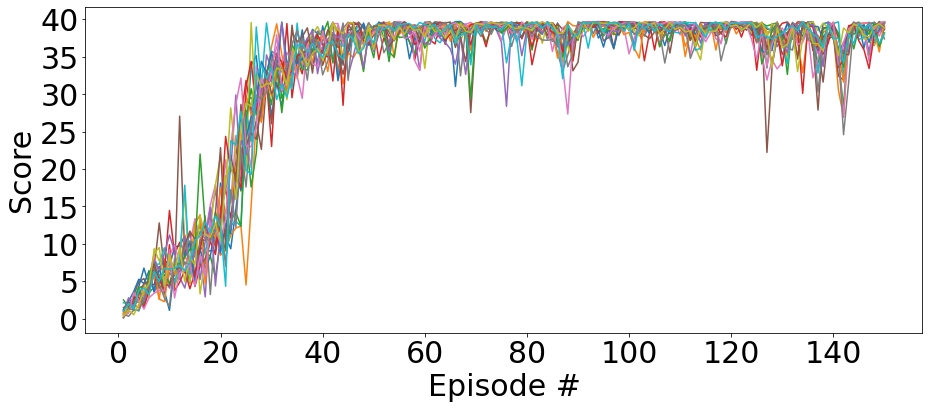

In [6]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
set_all_fontsizes(ax,30,False)
#plt.savefig('num_agent_20_individual', bbox_inches = 'tight')

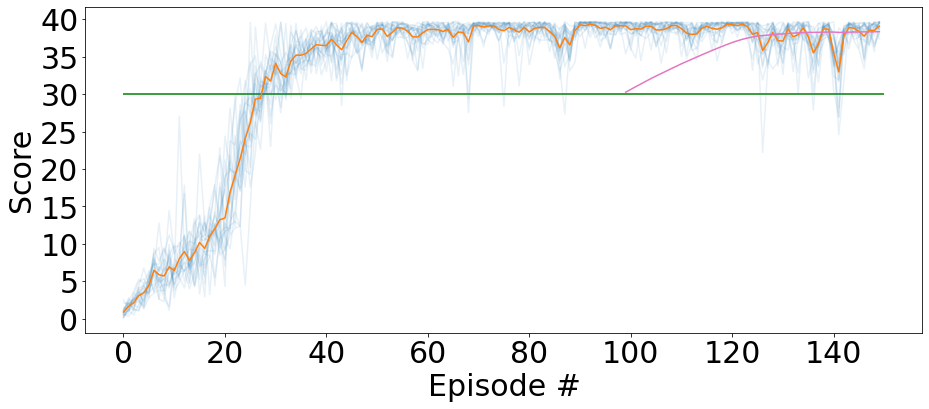

In [7]:
ax = pd.DataFrame(scores).plot(figsize=(15,6),color='C0',alpha=0.1)
mean_score = pd.DataFrame(scores).mean(axis=1)
ax1 = mean_score.plot(ax=ax,color='C1')
ax2 = mean_score.rolling(window=100).mean().plot(ax=ax,color='C6')
ax.get_legend().remove()
ax3 = ax.hlines(30,0,150,color='g')
plt.ylabel('Score')
plt.xlabel('Episode #')
set_all_fontsizes(ax,30,False)
#plt.savefig('num_agent_20', bbox_inches = 'tight')

### 6. Watch SMART agent

Load a check point from training above, and see how it performs. Set i_episode to desired number of training episodes. The training loop above dumps state for every 100th episodes by default.

In [8]:
i_episode = 100

agent = Agent_20(state_size=33, action_size=4, num_agents=20, random_seed=10)
for i in range(20):
    agent.actor_local[i].load_state_dict(torch.load('checkpoints/checkpoint_actor_20_{0}_{1}.pth'.format(i,i_episode)))

env = UnityEnvironment(file_name=env_path_n_file_name)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations               # get the current state
score = np.zeros(20)                               # initialize the score

while True:
    action = agent.act(state,False)                # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations      # get the next state
    reward = env_info.rewards                      # get the reward
    done = env_info.local_done                     # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if np.any(done):                               # exit loop if episode finished
        break
    
print('Final score for current game: {0}'.format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Final score for current game: [39.59999911 39.47999912 39.63999911 39.62999911 26.22999941 39.52999912
 32.14999928 37.19999917 34.06999924 34.59999923 36.76999918 39.53999912
 39.50999912 39.09999913 36.97999917 39.22999912 34.69999922 38.85999913
 39.58999912 36.13999919]
